In [2]:
import matplotlib.pyplot as plt #General Plotting
from matplotlib import cm
import numpy as np
from scipy.stats import multivariate_normal
from sklearn.metrics import confusion_matrix

# Set seed to generate reproducible "pseudo-randomness" (handles scipy's "randomness" too)
np.random.seed(4)



2
3
[0 1]
(10000,)
[   0    3    8 ... 9997 9998 9999]
[   1    2    4 ... 9992 9995 9996]


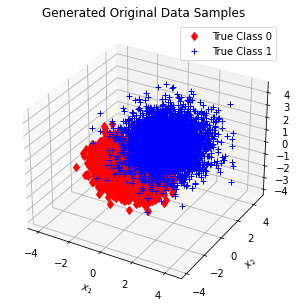

In [9]:
N = 10000
mu = np.array([[-1/2, -1/2, -1/2], [1, 1, 1]])

sigma = np.array([[[1,-0.5,0.3],
                   [-0.5,1,-0.5],
                   [0.3, -0.5, 1]],
                  [[1, 0.3, -0.2],
                   [0.3, 1, 0.3],
                   [-0.2, 0.3, 1]]])
                  
priors = np.array([0.65, 0.35])


n = mu.shape[1] # 
C = len(priors) # Classes
L = np.array(range(C)) # labels

print(C)
print(n)
print(L)

# Decide randomly which samples will come from each component
# np.random.rand creates an array of the given shape and populates it with random
# samples from a uniform distribution over [0,1). Similar to np.zeros or np.ones
u = np.random.rand(N)
print(u.shape)

# set thresholds: 0 -> 0.65 -> 1
thresholds = np.cumsum(priors)
thresholds = np.insert(thresholds,0,0)

# create empty matrix for samples of size 10,000 x 3
X = np.zeros([N,n])

# create empty labels array of length 10,000
labels = np.zeros(N)

# Plot for original data and their true labels
fig = plt.figure(figsize=(12, 10))
ax1 = fig.add_subplot(131, projection = '3d')
marker_shapes = 'd+.'
marker_colors = 'rbg' 

for i in range(C):

    # Find indices of u that meet each prior
    indices = np.argwhere((thresholds[i] <= u) & (u <= thresholds[i+1]))[:, 0]
    print(indices)

    # Get the number of indices in each component - should be ~ 6500 and 3500
    Nl = len(indices)
    
    # set label vector based on above - will be vector of class labels [0 0 1 0 1 .. to 9999] in this case
    # for more classes, this can be [1 2 2 0 1 3 1 3 0 ...]
    labels[indices] = i * np.ones(Nl)
    
    # for each valid index, fill the 
    X[indices, :] = multivariate_normal.rvs(mu[i], sigma[i], Nl)
    ax1.plot(X[labels==i, 0], X[labels==i, 1], X[labels==i, 2], marker_shapes[i] + marker_colors[i], label="True Class {}".format(i))


# Plot the original data and their true labels
plt.legend()
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.title("Generated Original Data Samples")
plt.tight_layout()
plt.show()



In [17]:
# Generate data distributions and store in true class labels
Nl = np.array([sum(labels == i) for i in range(C)])
print("Num samples: 0 = {}, 1 = {}".format(Nl[0],Nl[1]))

Num samples: 0 = 6511, 1 = 3489


[-7.21825054  0.28938452 13.65946513 ... -3.51724737 -0.93024373
 -4.25013151]
1.8571428571428574
(2,)


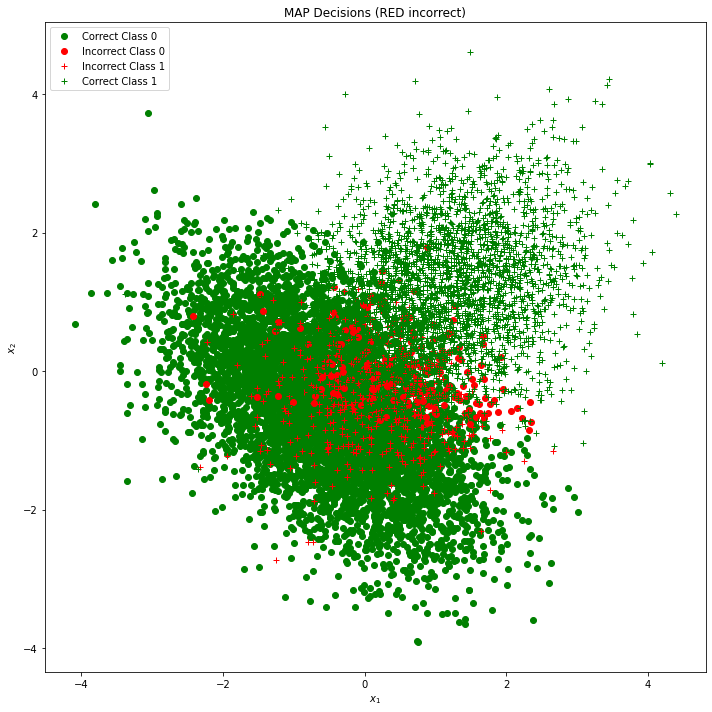

In [19]:
class_conditional_likelihoods = np.array([multivariate_normal.pdf(X, mu[l], sigma[l]) for l in L])
discriminant_score_erm = np.log(class_conditional_likelihoods[1]) - np.log(class_conditional_likelihoods[0])

print(discriminant_score_erm)

Lambda = np.ones((C, C)) - np.identity(C)
# Theoretical / Expected
gamma_map = (Lambda[1,0] - Lambda[0,0]) / (Lambda[0,1] - Lambda[1,1]) * priors[0]/priors[1]
print(gamma_map)


decisions_map = discriminant_score_erm >= np.log(gamma_map)

# Get indices and probability estimates of the four decision scenarios:
# (true negative, false positive, false negative, true positive)

# True Negative Probability
ind_00_map = np.argwhere((decisions_map==0) & (labels==0))
p_00_map = len(ind_00_map) / Nl[0]
# False Positive Probability
ind_10_map = np.argwhere((decisions_map==1) & (labels==0))
p_10_map = len(ind_10_map) / Nl[0]
# False Negative Probability
ind_01_map = np.argwhere((decisions_map==0) & (labels==1))
p_01_map = len(ind_01_map) / Nl[1]
# True Positive Probability
ind_11_map = np.argwhere((decisions_map==1) & (labels==1))
p_11_map = len(ind_11_map) / Nl[1]

# Probability of error for MAP classifier, empirically estimated
prob_error_erm = np.array((p_10_map, p_01_map)).dot(Nl.T / N)
print(np.array((p_10_map, p_01_map)).shape)
# Display MAP decisions
fig = plt.figure(figsize=(10, 10))

# class 0 circle, class 1 +, correct green, incorrect red
plt.plot(X[ind_00_map, 0], X[ind_00_map, 1], 'og', label="Correct Class 0")
plt.plot(X[ind_10_map, 0], X[ind_10_map, 1], 'or', label="Incorrect Class 0")
plt.plot(X[ind_01_map, 0], X[ind_01_map, 1], '+r', label="Incorrect Class 1")
plt.plot(X[ind_11_map, 0], X[ind_11_map, 1], '+g', label="Correct Class 1")

plt.legend()
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.title("MAP Decisions (RED incorrect)")
plt.tight_layout()
plt.show()


In [59]:
from sys import float_info # Threshold smallest positive floating value

# Generate ROC curve samples
def estimate_roc(discriminant_score, label):
    Nlabels = np.array((sum(label == 0), sum(label == 1)))

    sorted_score = sorted(discriminant_score)

    # Use tau values that will account for every possible classification split
    taus = ([sorted_score[0] - float_info.epsilon] + 
             sorted_score +
             [sorted_score[-1] + float_info.epsilon])
        
    # Calculate the decision label for each observation for each gamma
    decisions = [discriminant_score >= t for t in taus]

    ind10 = [np.argwhere((d==1) & (label==0)) for d in decisions]
    p10 = [len(inds)/Nlabels[0] for inds in ind10]
    ind11 = [np.argwhere((d==1) & (label==1)) for d in decisions]
    p11 = [len(inds)/Nlabels[1] for inds in ind11]
    print(len(ind10))
    print(len(p10))
    prob_error = [(p10[w] *priors[0] + (1 - p11[w])* priors[1]) for w in range(len(p10))]
    minimum_error = min(prob_error)
    print(minimum_error) # YAYYYYY

    # ROC has FPR on the x-axis and TPR on the y-axis
    roc = np.array((p10, p11))

    return roc, taus

In [60]:
print(priors[0])
roc_erm, _= estimate_roc(discriminant_score_erm, labels)


0.65
10002
10002
0.058979653411016554


In [49]:
# Construct the ROC for ERM by changing log(gamma)
roc_erm, _= estimate_roc(discriminant_score_erm, labels)
roc_map = np.array((p_10_map, p_11_map))
print(roc_map)

fig_roc, ax_roc = plt.subplots(figsize=(10, 10))
ax_roc.plot(roc_erm[0], roc_erm[1])
ax_roc.plot(roc_map[0], roc_map[1], 'rx', label="Minimum P(Error) MAP", markersize=16)
ax_roc.legend()
ax_roc.set_xlabel(r"Probability of false alarm $P(D=1|L=0)$")
ax_roc.set_ylabel(r"Probability of correct decision $P(D=1|L=1)$")
plt.grid(True)

fig_roc;

10002
10002


TypeError: can't multiply sequence by non-int of type 'numpy.float64'

In [5]:
class_cond_likelihood = np.array([multivariate_normal.pdf(X, mu[c], sigma[c]) for c in range(C)])
print(class_cond_likelihood)
print(priors.shape)
class_priors = np.diag(priors)
print(class_priors)
class_posteriors = class_priors.dot(class_cond_likelihood)
print(class_posteriors)

# MAP rule (maximum a posteriori!!!)
decisions = np.argmax(class_posteriors, axis=0)
print(decisions.shape)
print(decisions[0]) # compute these across every column 


# Simply using sklearn confusion matrix
conf_mat = confusion_matrix(decisions, labels)
print(conf_mat)

correct_class_counts = np.diag(conf_mat)
correct_class_total = np.sum(correct_class_counts)
print('misclassified count: {}'.format(N-correct_class_total))

prob_error = 1 - (correct_class_total)/N
print("Empirically Estimated Probability of Error: {:.4f}".format(prob_error))

[[1.35328706e-10 6.14419932e-03 4.94095142e-03 ... 5.10451820e-02
  1.09793939e-02 1.37696340e-02]
 [1.73196166e-02 7.35216675e-07 3.30460804e-02 ... 1.14753849e-02
  7.17440403e-07 2.89558559e-02]]
(2,)
[[0.65 0.  ]
 [0.   0.35]]
[[8.79636592e-11 3.99372956e-03 3.21161842e-03 ... 3.31793683e-02
  7.13660607e-03 8.95026207e-03]
 [6.06186581e-03 2.57325836e-07 1.15661281e-02 ... 4.01638473e-03
  2.51104141e-07 1.01345496e-02]]
(10000,)
1
[[6291  391]
 [ 193 3125]]
misclassified count: 584
Empirically Estimated Probability of Error: 0.0584


In [33]:
# PART A

# Define Discriminators 
N0_discriminant = []
N1_discriminant = []

# Discriminant scores for all datapoints in each distribution (number of 'hits') using
# multivariate Gaussian probability density function
for j in range(0, Nl[0]):
    N0_discriminant.append(multivariate_normal.pdf(X[0][j], mu[1], sigma[1])/multivariate_normal.pdf(r0[j], mu[0], sigma[0]))
for j in range(0, Nl[1]):
    N1_discriminant.append(multivariate_normal.pdf(r1[j], mu[1], sigma[1])/multivariate_normal.pdf(r1[j], mu[0], sigma[0])) # CUT OFF
    
false_positive =[]
true_positive =[]
prob_error =[]
gamma_values =[]

# concatenate
full_discriminant= N0_discriminant + N1_discriminant
full_discriminant.append(0)

# sweep gamma/threshold value and compute true positive (detected) and false positive (false alarm)
# Instead of testing values from 0 - infty, we test between 
# across the two discriminants core lists (plus a 0 value), so in each loop one new value ...
# begin >= 0 and are eventually <= the maximum value
for i in sorted(full_discriminant):
    fp = len([ j for j in N0_discriminant if j >=i ])/ Nl[0]
    tp = len([ j for j in N1_discriminant if j >=i ])/ Nl[1]
    false_positive.append(fp)
    true_positive.append(tp)    
    gamma_values.append(i)
    prob_error.append(fp *p0 + (1 - tp)* p1)

# Find experimental minimum error and corresponding index
minimum_error = min(prob_error)
minimum_index = 0
for i in range(0, len(prob_error)):
    if prob_error [i] == minimum_error:
        minimum_index = i
        break

print('PartA')
print('Experimental Gamma ')
print(gamma_values[minimum_index])
print('Experimental min_error ')
print (minimum_error)

# Calculate Theoretical Minimum error
theo_fp = len([ j for j in N0_discriminant if j >=(p0/p1) ])/ Nl[0]
theo_tp = len([ j for j in N1_discriminant if j >=(p0/p1) ])/ N1
print('Theor eti cal Eror ')
print(theo_fp *p0 + (1- theo_tp)* p1)

# plot with two additional datapoints ???
plt.figure(1)
plt.plot(false_positive,true_positive,label= 'ROC Curve ')
plt.plot(false_positive [minimum_index],true_positive [minimum_index], 'ro',label= ' Experimental' )
plt.plot(theo_fp, theo_tp, 'g+ ',label= ' Theor eti cal Minimum Eror ')
plt.title('Minimum Expected Risk ROC Curve ')
plt.ylabel('P( Cor rectDetection)')
plt.xlabel('P( False Positiv e)')
plt.legend()
plt.show()



TypeError: 'int' object is not subscriptable

PartB 
Experimental Gamma 
2.534269785427277
Experimental min_error 
0.06082066716776886
Theor eti cal Eror 
0.07601067895139096


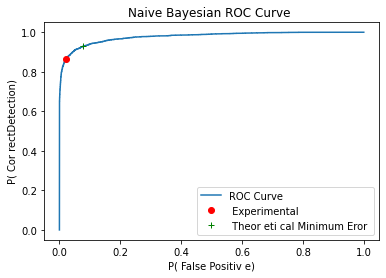

In [40]:
# Part B
# Set sigma to identity matrix
sigma_nb = np.array([[1, 0, 0],[0, 1, 0],[0, 0, 1] ])
N0_discriminant = []
N1_discriminant = []

# Calculate discriminant score as above
for j in range(0, N0):
    N0_discriminant.append(multivariate_normal.pdf(r0[j], mu1, sigma_nb)/multivariate_normal.pdf(r0[j], mu0, sigma0))
for j in range(0, N1):
    N1_discriminant.append(multivariate_normal.pdf(r1[j], mu1, sigma_nb)/multivariate_normal.pdf(r1[j], mu0, sigma0))

false_positive =[]
true_positive =[]
prob_error =[]
gamma_values =[]

full_discriminant= N0_discriminant + N1_discriminant
full_discriminant.append(0)
# deciding for all possible gammas using the same logic as part A
for i in sorted(full_discriminant):
    fp = len([ j for j in N0_discriminant if j >=i ])/ N0
    tp = len([ j for j in N1_discriminant if j >=i ])/ N1
    false_positive.append(fp)
    true_positive.append(tp)
    gamma_values.append(i)
    prob_error.append(fp *p0 + (1 - tp)* p1)

# minimum_error = min( prob_error)
# minimum_index = 0
# for i in range(0, len(prob_error)) :
#     if prob_error [i] == minimum_error :
#         minimum_index = i
#         break

print('PartB ')
print('Experimental Gamma ')
print(gamma_values [minimum_index ])
print('Experimental min_error ')
print (min( prob_error))
print('Theor eti cal Eror ')
theo_fp = len([ j for j in N0_discriminant if j >=(p1/p0) ])/ N0
theo_tp = len([ j for j in N1_discriminant if j >=(p1/p0) ])/ N1
print(theo_fp *p0 + (1- theo_tp)* p1)

# Plot
plt.figure(2)
plt.plot(false_positive,true_positive,label= 'ROC Curve ')
plt.plot(false_positive[minimum_index],true_positive[minimum_index], 'ro',label= ' Experimental ')
plt.plot(theo_fp, theo_tp, 'g+ ',label= ' Theor eti cal Minimum Eror ')
plt.title('Naive Bayesian ROC Curve ')
plt.ylabel('P( Cor rectDetection)')
plt.xlabel('P( False Positiv e)')
plt.legend()
plt.show()

PartC
Experimental Gamma 
0.4207622779803293
Experimental min_error 
0.08040124471286952
Theor eti cal Eror 
0.08077100237067185


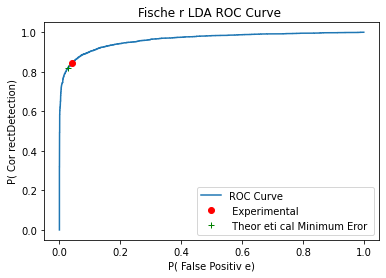

In [13]:


# Part C
# Simple Function to get average of a list
def get_average(list):
    return sum( list)/ len(list)

# calculate mu projections
mu0proj = np.transpose(np.array([get_average(r0[:, 0]), get_average(r0[:, 1]), get_average(r0[:, 2])]))
mu1proj = np.transpose(np.array([get_average(r1[:, 0]), get_average(r1[:, 1]), get_average(r1[:, 2])]))# calculate covaria nceproj e ction s
sigma0proj = np.cov(r0, rowvar=False)
sigma1proj = np.cov(r1, rowvar=False)

# calculate between scatter and within scatter
Sb = (mu0proj - mu1proj)* np.transpose (mu0proj - mu1proj)
Sw = sigma0proj + sigma1proj

# get eigenvectors and eigenvalues from Sw^-1 * Sb
w, v = np.linalg.eig(np.linalg.inv(Sw) * Sb)
max_eigen_index = 0

# find index of maximum eigenvalue
for i in range(0, len (w)):
    if w[i] == max(w) :
        max_eigen_index = i


# assign wLDA to correct eigenvector and calculate LDA for 2 distributions
# Note : for some r eason numpy hasb othth e wLDA andth e d ataal r ead ytranspos e dsothis fix # formul a
wLDA = v[:, max_eigen_index]
yLDA0 = np.matmul(wLDA, r0.T)
yLDA1 = np.matmul(wLDA, r1.T)
totalLDA = list(yLDA0) + list(yLDA1)
false_positive =[]
true_positive =[]
prob_error =[]
gamma_values =[]
# us e same logic asa bov eto make d e cisio n s
for i in sorted(totalLDA):
    fp = len([ j for j in yLDA0 if j >=i ])/ N0
    tp = len([ j for j in yLDA1 if j >=i ])/ N1
    false_positive.append(fp)
    true_positive.append(tp)
    gamma_values.append(i)
    prob_error.append(fp *p0 + (1 - tp)* p1)

minimum_error = min( prob_error)
minimum_index = 0
for i in range(0, len(prob_error)) :
    if prob_error [i] == minimum_error :
        minimum_index = i
        break

print('PartC')
print('Experimental Gamma ')
print(gamma_values[minimum_index])
print('Experimental min_error ')
print (min( prob_error))
print('Theor eti cal Eror ')
theo_fp = len([ j for j in yLDA0 if j >=(p1/p0) ])/ N0
theo_tp = len([ j for j in yLDA1 if j >=(p1/p0) ])/ N1
print(theo_fp *p0 + (1- theo_tp)* p1)

# plotd ata
plt.figure(3)
plt.plot(false_positive,true_positive,label= 'ROC Curve ')
plt.plot(false_positive [minimum_index],true_positive [minimum_index], 'ro',label= ' Experimental ')
plt.plot(theo_fp, theo_tp, 'g+',label= ' Theor eti cal Minimum Eror ')
plt.title('Fische r LDA ROC Curve ')
plt.ylabel('P( Cor rectDetection)')
plt.xlabel('P( False Positiv e)')
plt.legend()
plt.show()